In [7]:
import pandas as pd

# URL do dataset
url = "https://raw.githubusercontent.com/josenalde/machinelearning/main/src/dataset/loan.csv"

# Carregar o dataset
try:
    df = pd.read_csv(url)
    print("Dataset carregado com sucesso!")
    print("\nPrimeiras 5 linhas do dataset:")
    print(df.head())
    print("\nInformações do dataset:")
    df.info()
    print("\nFormato do dataset (linhas, colunas):", df.shape)

except Exception as e:
    print(f"Ocorreu um erro ao carregar o dataset: {e}")

Dataset carregado com sucesso!

Primeiras 5 linhas do dataset:
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1  

In [8]:
# 1. Remover colunas específicas 
columns_to_drop = ['Loan_ID', 'CoapplicantIncome', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']
df = df.drop(columns=columns_to_drop)
print(f"\nColunas removidas: {columns_to_drop}")
print("Novas colunas após remoção:", df.columns.tolist())
print("Novo formato do dataset:", df.shape)

# 2. Preencher dados faltantes com a moda para as colunas especificadas 
# Colunas a serem preenchidas com a moda
cols_for_mode_imputation = ['Gender', 'Married', 'Dependents', 'Self_Employed']

for col in cols_for_mode_imputation:
    if df[col].isnull().any(): # Verifica se há valores nulos na coluna
        mode_val = df[col].mode()[0] # Calcula a moda (pode haver mais de uma, pega a primeira)
        df[col].fillna(mode_val, inplace=True)
        print(f"Preenchidos valores faltantes em '{col}' com a moda: '{mode_val}'")

# 3. Tratar a feature 'Dependents': associar '3+' ao rótulo '3' 
# Primeiro, certificar que a coluna é string para poder usar .replace()
df['Dependents'] = df['Dependents'].astype(str).str.replace('3+', '3', regex=False)
print("\nColuna 'Dependents' após tratamento de '3+':")
print(df['Dependents'].value_counts())

# 4. Confirmar se não há mais dados faltantes 
print("\nVerificando dados faltantes após o tratamento:")
print(df.isnull().sum())

# Salvar o DataFrame atualizado para a próxima etapa (opcional, mas bom para checkpoint)
# df.to_csv("loan_processed_step1.csv", index=False)


Colunas removidas: ['Loan_ID', 'CoapplicantIncome', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']
Novas colunas após remoção: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'LoanAmount', 'Loan_Status']
Novo formato do dataset: (614, 8)
Preenchidos valores faltantes em 'Gender' com a moda: 'Male'
Preenchidos valores faltantes em 'Married' com a moda: 'Yes'
Preenchidos valores faltantes em 'Dependents' com a moda: '0'
Preenchidos valores faltantes em 'Self_Employed' com a moda: 'No'

Coluna 'Dependents' após tratamento de '3+':
Dependents
0    360
1    102
2    101
3     51
Name: count, dtype: int64

Verificando dados faltantes após o tratamento:
Gender              0
Married             0
Dependents          0
Education           0
Self_Employed       0
ApplicantIncome     0
LoanAmount         22
Loan_Status         0
dtype: int64


C:\Users\alfre\AppData\Local\Temp\ipykernel_15124\3501790731.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_val, inplace=True)


In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler # Adicionado StandardScaler aqui
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer # Para garantir que não há mais nulos em caso de problemas futuros (embora já tenhamos tratado)

# O df já deve estar carregado de uma célula anterior. Se estiver rodando esta célula sozinha, certifique-se que df está disponível.
# Se você está rodando esta célula sozinha e o df não está definido, execute a primeira célula de carregamento do dataset novamente.

# 1. Preencher valores faltantes em 'LoanAmount' com a mediana
if df['LoanAmount'].isnull().any():
    median_loanamount = df['LoanAmount'].median()
    df['LoanAmount'].fillna(median_loanamount, inplace=True)
    print(f"\nPreenchidos valores faltantes em 'LoanAmount' com a mediana: {median_loanamount}")

# Confirmar se não há mais dados faltantes em todo o DataFrame
print("\nVerificando dados faltantes após o tratamento de 'LoanAmount':")
print(df.isnull().sum())

# 2. Transformar features categóricas
# Identificar colunas categóricas e a variável target
target_col = 'Loan_Status' # A variável target Loan_Status também é categórica

# Aplicar LabelEncoder na variável target
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col])
print(f"\nVariável target '{target_col}' transformada. Classes mapeadas: {le.classes_} -> {le.transform(le.classes_)}")

# Separar features (X) e target (y)
X = df.drop(columns=[target_col])
y = df[target_col]

# Identificar colunas numéricas e categóricas (após drop e tratamento de Dependents)
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# No caso de Dependents, apesar de ter sido tratado como string, agora ele tem apenas '0','1','2','3'
# e pode ser tratado como numérico ou transformado para one-hot se considerarmos suas categorias.
# A questão não especifica se 'Dependents' deve ser numérica ou categórica após '3+'.
# Vamos tratá-la como categórica para OneHotEncoder, por ser discreta e ter poucas categorias.
if 'Dependents' in numerical_cols: # Remover de numericas se foi tratado como object
    numerical_cols = numerical_cols.drop('Dependents')
if 'Dependents' not in categorical_cols: # Adicionar em categoricas
    categorical_cols = categorical_cols.append(pd.Index(['Dependents']))


print(f"\nColunas numéricas identificadas para padronização: {list(numerical_cols)}")
print(f"Colunas categóricas identificadas para OneHotEncoder: {list(categorical_cols)}")

# Criar transformadores para as colunas
# O OneHotEncoder será aplicado às colunas categóricas.
# O StandardScaler será aplicado às colunas numéricas.

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline([
            ('onehot', OneHotEncoder(handle_unknown='ignore')) # handle_unknown='ignore' para novas categorias
        ]), categorical_cols)
    ])

print("\nPré-procSessador (ColumnTransformer) configurado.")
print("Pronto para a criação de pipelines e treino dos modelos.")


Preenchidos valores faltantes em 'LoanAmount' com a mediana: 128.0

Verificando dados faltantes após o tratamento de 'LoanAmount':
Gender             0
Married            0
Dependents         0
Education          0
Self_Employed      0
ApplicantIncome    0
LoanAmount         0
Loan_Status        0
dtype: int64

Variável target 'Loan_Status' transformada. Classes mapeadas: ['N' 'Y'] -> [0 1]

Colunas numéricas identificadas para padronização: ['ApplicantIncome', 'LoanAmount']
Colunas categóricas identificadas para OneHotEncoder: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed']

Pré-procSessador (ColumnTransformer) configurado.
Pronto para a criação de pipelines e treino dos modelos.


C:\Users\alfre\AppData\Local\Temp\ipykernel_15124\2813022805.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['LoanAmount'].fillna(median_loanamount, inplace=True)


Iniciando Grid Search e validação cruzada COM BALANCEAMENTO (SMOTE) para cada modelo...

------ Processando: Logistic Regression (com SMOTE) ------
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores parâmetros para Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l1'}
Melhor score (AUC) na validação cruzada para Logistic Regression (com SMOTE): 0.5392
ROC AUC Score no conjunto completo (avaliação): 0.5910
Classification Report para Logistic Regression:
              precision    recall  f1-score   support

           0       0.38      0.59      0.46       192
           1       0.75      0.55      0.64       422

    accuracy                           0.57       614
   macro avg       0.56      0.57      0.55       614
weighted avg       0.63      0.57      0.58       614


------ Processando: Decision Tree (com SMOTE) ------
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores parâmetros para Decision Tree: {'classifier__max_depth

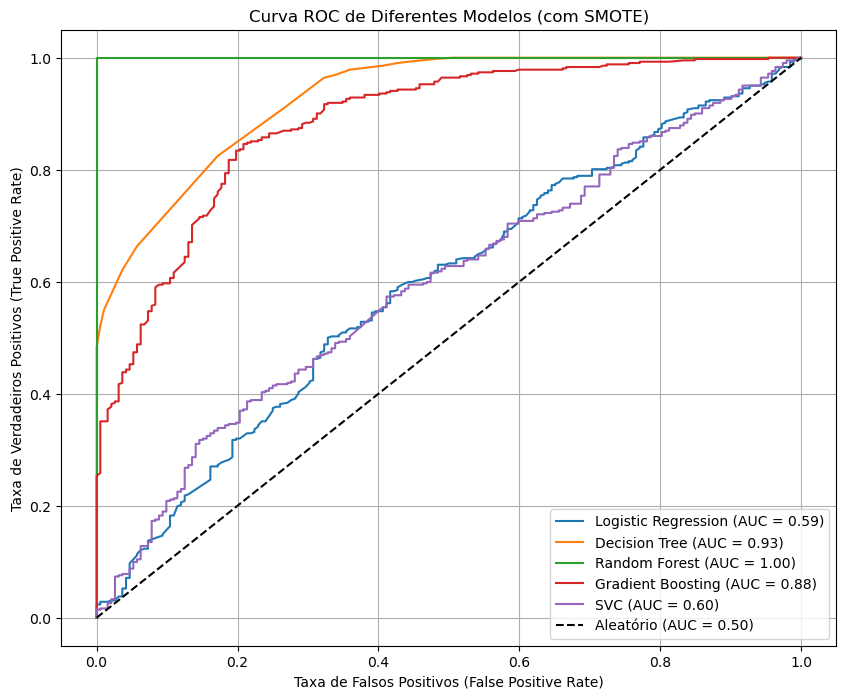

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline as ImbPipeline # Importar Pipeline do imblearn
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Definir os algoritmos e seus respectivos parâmetros para o Grid Search
# Agora usando ImbPipeline para incluir o SMOTE

pipelines = {
    'Logistic Regression': ImbPipeline(steps=[('preprocessor', preprocessor),
                                              ('smote', SMOTE(random_state=42)),
                                              ('classifier', LogisticRegression(random_state=42, solver='liblinear'))]),
    'Decision Tree': ImbPipeline(steps=[('preprocessor', preprocessor),
                                        ('smote', SMOTE(random_state=42)),
                                        ('classifier', DecisionTreeClassifier(random_state=42))]),
    'Random Forest': ImbPipeline(steps=[('preprocessor', preprocessor),
                                         ('smote', SMOTE(random_state=42)),
                                         ('classifier', RandomForestClassifier(random_state=42))]),
    'Gradient Boosting': ImbPipeline(steps=[('preprocessor', preprocessor),
                                             ('smote', SMOTE(random_state=42)),
                                             ('classifier', GradientBoostingClassifier(random_state=42))]),
    'SVC': ImbPipeline(steps=[('preprocessor', preprocessor),
                               ('smote', SMOTE(random_state=42)),
                               ('classifier', SVC(random_state=42, probability=True))])
}

param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2']
    },
    'Decision Tree': {
        'classifier__max_depth': [None, 5, 10],
        'classifier__min_samples_leaf': [1, 5]
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [None, 10],
        'classifier__min_samples_leaf': [1, 5]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_depth': [3, 5]
    },
    'SVC': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    }
}

best_models = {}
roc_auc_scores = {}
classification_reports = {}

print("Iniciando Grid Search e validação cruzada COM BALANCEAMENTO (SMOTE) para cada modelo...")

# Para garantir a reprodutibilidade dos resultados da validação cruzada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, pipeline in pipelines.items():
    print(f"\n------ Processando: {name} (com SMOTE) ------")
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_strategy,
                               scoring='roc_auc', n_jobs=-1, verbose=1)

    grid_search.fit(X, y)

    best_models[name] = grid_search.best_estimator_

    y_pred = best_models[name].predict(X)
    y_pred_proba = best_models[name].predict_proba(X)[:, 1]

    roc_auc = roc_auc_score(y, y_pred_proba)
    report = classification_report(y, y_pred)

    roc_auc_scores[name] = roc_auc
    classification_reports[name] = report

    print(f"\nMelhores parâmetros para {name}: {grid_search.best_params_}")
    print(f"Melhor score (AUC) na validação cruzada para {name} (com SMOTE): {grid_search.best_score_:.4f}")
    print(f"ROC AUC Score no conjunto completo (avaliação): {roc_auc:.4f}")
    print(f"Classification Report para {name}:\n{report}")

print("\n======== Resumo dos Melhores Modelos (com SMOTE) ========")
for name in best_models:
    print(f"\nModelo: {name}")
    print(f"  ROC AUC Score: {roc_auc_scores[name]:.4f}")

# Opcional: Visualizar Curvas ROC para Comparação
plt.figure(figsize=(10, 8))
for name in best_models:
    y_pred_proba = best_models[name].predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_scores[name]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.50)')
plt.xlabel('Taxa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiros Positivos (True Positive Rate)')
plt.title('Curva ROC de Diferentes Modelos (com SMOTE)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Iniciando Grid Search e validação cruzada COM BALANCEAMENTO (SMOTE) para cada modelo...

------ Processando: Logistic Regression (com SMOTE) ------
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores parâmetros para Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l1'}
Melhor score (AUC) na validação cruzada para Logistic Regression (com SMOTE): 0.5392
ROC AUC Score no conjunto completo (avaliação): 0.5910
Classification Report para Logistic Regression:
              precision    recall  f1-score   support

           0       0.38      0.59      0.46       192
           1       0.75      0.55      0.64       422

    accuracy                           0.57       614
   macro avg       0.56      0.57      0.55       614
weighted avg       0.63      0.57      0.58       614


------ Processando: Decision Tree (com SMOTE) ------
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores parâmetros para Decision Tree: {'classifier__max_depth

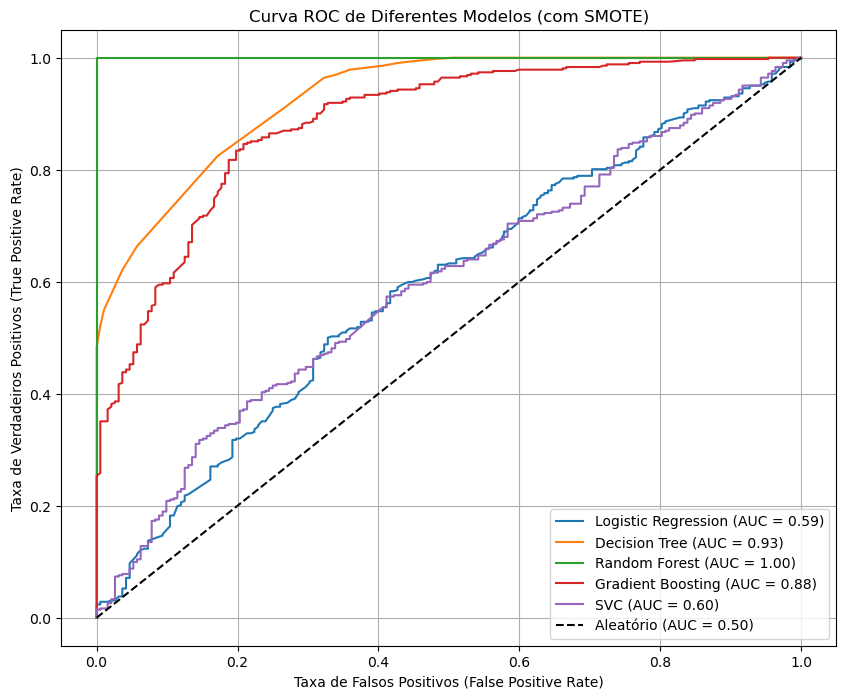

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline as ImbPipeline # Importar Pipeline do imblearn
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Definir os algoritmos e seus respectivos parâmetros para o Grid Search
# Agora usando ImbPipeline para incluir o SMOTE

pipelines = {
    'Logistic Regression': ImbPipeline(steps=[('preprocessor', preprocessor),
                                              ('smote', SMOTE(random_state=42)),
                                              ('classifier', LogisticRegression(random_state=42, solver='liblinear'))]),
    'Decision Tree': ImbPipeline(steps=[('preprocessor', preprocessor),
                                        ('smote', SMOTE(random_state=42)),
                                        ('classifier', DecisionTreeClassifier(random_state=42))]),
    'Random Forest': ImbPipeline(steps=[('preprocessor', preprocessor),
                                         ('smote', SMOTE(random_state=42)),
                                         ('classifier', RandomForestClassifier(random_state=42))]),
    'Gradient Boosting': ImbPipeline(steps=[('preprocessor', preprocessor),
                                             ('smote', SMOTE(random_state=42)),
                                             ('classifier', GradientBoostingClassifier(random_state=42))]),
    'SVC': ImbPipeline(steps=[('preprocessor', preprocessor),
                               ('smote', SMOTE(random_state=42)),
                               ('classifier', SVC(random_state=42, probability=True))])
}

param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2']
    },
    'Decision Tree': {
        'classifier__max_depth': [None, 5, 10],
        'classifier__min_samples_leaf': [1, 5]
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [None, 10],
        'classifier__min_samples_leaf': [1, 5]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_depth': [3, 5]
    },
    'SVC': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    }
}

best_models = {}
roc_auc_scores = {}
classification_reports = {}

print("Iniciando Grid Search e validação cruzada COM BALANCEAMENTO (SMOTE) para cada modelo...")

# Para garantir a reprodutibilidade dos resultados da validação cruzada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, pipeline in pipelines.items():
    print(f"\n------ Processando: {name} (com SMOTE) ------")
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_strategy,
                               scoring='roc_auc', n_jobs=-1, verbose=1)

    grid_search.fit(X, y)

    best_models[name] = grid_search.best_estimator_

    y_pred = best_models[name].predict(X)
    y_pred_proba = best_models[name].predict_proba(X)[:, 1]

    roc_auc = roc_auc_score(y, y_pred_proba)
    report = classification_report(y, y_pred)

    roc_auc_scores[name] = roc_auc
    classification_reports[name] = report

    print(f"\nMelhores parâmetros para {name}: {grid_search.best_params_}")
    print(f"Melhor score (AUC) na validação cruzada para {name} (com SMOTE): {grid_search.best_score_:.4f}")
    print(f"ROC AUC Score no conjunto completo (avaliação): {roc_auc:.4f}")
    print(f"Classification Report para {name}:\n{report}")

print("\n======== Resumo dos Melhores Modelos (com SMOTE) ========")
for name in best_models:
    print(f"\nModelo: {name}")
    print(f"  ROC AUC Score: {roc_auc_scores[name]:.4f}")

# Opcional: Visualizar Curvas ROC para Comparação
plt.figure(figsize=(10, 8))
for name in best_models:
    y_pred_proba = best_models[name].predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_scores[name]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.50)')
plt.xlabel('Taxa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiros Positivos (True Positive Rate)')
plt.title('Curva ROC de Diferentes Modelos (com SMOTE)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [13]:
import joblib

# O modelo 'Decision Tree' foi escolhido como o melhor
# Ele está armazenado no dicionário best_models
best_decision_tree_model = best_models['Decision Tree']

# Salvar o pipeline completo
# O nome do arquivo será 'loan_approval_model.pkl'
joblib.dump(best_decision_tree_model, 'loan_approval_model.pkl')

print("Modelo 'Decision Tree' salvo com sucesso como 'loan_approval_model.pkl'")
print("\nVocê pode encontrar o arquivo 'loan_approval_model.pkl' no mesmo diretório do seu notebook.")

Modelo 'Decision Tree' salvo com sucesso como 'loan_approval_model.pkl'

Você pode encontrar o arquivo 'loan_approval_model.pkl' no mesmo diretório do seu notebook.


In [14]:
import os
print(os.getcwd())

C:\Users\alfre\OneDrive\Documentos\Questao1
